# Plot Neutrino Distributions

### Load Libraries

In [36]:
#from Code import *
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib

## Files

The files `events_*.csv` contains a MC samples of neutrino events passing through a 1m x 1m centered around line-of-sight at z=480m. Each event is specified by   
- `vpid`: the eutrino particle ID 
- `hpid`: the primary hadron particle ID
- `x0`: the x-position at z=480m in units of [m]
- `y0`: the y-position at z=480m in units of [m]
- `thx`: the x-angle, defined as px/pz
- `thy`: the x-angle, defined as py/pz
- `en`: the neutrino energy in units of [GeV]
- `w`: the event weight in units of [pb] 
- `iEvent`: the event identifier used in the `weight_*.csv` file 

In the following, we show one example. 

In [27]:
pd.read_csv("events_charm_13.6TeV_POWHEG-smallxLHCb_P8-Monash_0.csv.gzip",compression='gzip',nrows=5)

,vpid,hpid,x0,y0,...,thy,en,w,iEvent
0,-12,-411,-0.416,0.225,...,0.468,29.6,8.8415,5
1,12,411,-0.217,0.207,...,0.430,15.6,8.8415,6
2,12,421,-0.370,0.122,...,0.255,94.6,3.5168,12
3,12,421,-0.157,-0.261,...,-0.545,158.9,3.5168,12
4,12,421,0.400,0.169,...,0.352,180.5,3.5168,12


The files `weights_*.csv` contains a samples of primary collision events. For each event we specify the unique the event identifier `iEvent` as well as the relative cross section $r_{IJ}=\sigma_{IJ} / \sigma_{11}$ for the following setups, where the labels `IJ` correspond to 
- `11`: the default setup with $\mu_R = \mu_F=\mu_0$
- `12`: the scale variation setup with $\mu_R =\mu_0$ and $\mu_F = 2\mu_0$ 
- `21`: the scale variation setup with $\mu_R =2\mu_0$ and $\mu_F = \mu_0$ 
- `22`: the scale variation setup with $\mu_R =2\mu_0$ and $\mu_F = 2\mu_0$ 
- `H1`: the scale variation setup with $\mu_R =0.5\mu_0$ and $\mu_F = \mu_0$ 
- `1H`: the scale variation setup with $\mu_R =\mu_0$ and $\mu_F = 0.5\mu_0$ 
- `HH`: the scale variation setup with $\mu_R =0.5\mu_0$ and $\mu_F = 0.5\mu_0$ 

In the following, we show one example. 

In [29]:
pd.read_csv("weights_charm_13.6TeV_POWHEG-smallxLHCb_P8-Monash.csv.gzip",compression='gzip',nrows=5)

,iEvent,11,12,21,22,1H,H1,HH
0,0,1.0,2.1689,0.4711,1.1029,1.0985,2.5456,2.8963
1,1,1.0,1.9236,0.5977,1.5048,0.9224,1.8132,1.9819
2,2,1.0,2.1882,0.4948,1.1557,0.9342,2.4000,2.3127
3,3,1.0,2.0842,0.4488,1.0012,1.1533,2.4920,2.9205
4,4,1.0,2.1533,0.5457,1.2101,0.4178,2.3185,1.0110


## Get Interaction and Probability

The probability of a neutrino to interact in a detector with length $L$ and density $\rho$ is $P = \sigma\, L \,\rho / m_p$, where $m_p$ is the proton mass and $\sigma$ is the energy dependent neutrino nucleon cross section. Here we use the cross section obtained by GENIE in [1908.02310](https://arxiv.org/abs/1908.02310) for a tungsten target. 

## Get individual spectra with Reweighting 

The following function reads the event and weight files and plots the neutrino energy spectra. The input variables are:

- `label`: identifier of the files, for example `charm`, to load all files with the name `'events_'+label+'_*.csv.gzip'`
- `interaction`: whether to plot the energy spectrum of interacting neutrinos or of the throughgoing neutrinos. This assumes a tungsten target. 
- `pids`: select subset of neutrinos to consider, for example `[12,-12]` for electron neutrinos and anti-neutrinos
- `xmin, xmax, ymin, ymax`: dimensions of detector in transverse plane, in units of meter. 
- `posz`: z-position of detector, for example 480m for FASER 
- `lumi`: luminosity in inverse fb 
- `length`: length of the detector 

In [98]:
def plot(
        label, 
        interaction = True,
        pids=[12,-12], 
        xmin=-.125, xmax=.125, 
        ymin=-.125, ymax=.125, 
        posz=480, lumi=200, length=100,
    ):
    
    # setup figure
    matplotlib.rcParams.update({'font.size': 14})
    matplotlib.rcParams['text.usetex'] = False
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(1,1,1)  
    
    # title string
    pidstr=""
    if  12 in pids: pidstr +=r"$\nu_e$+"
    if -12 in pids: pidstr +=r"$\bar\nu_e$+"
    if  14 in pids: pidstr +=r"$\nu_\mu$+"
    if -14 in pids: pidstr +=r"$\bar\nu_\mu$+"
    if  16 in pids: pidstr +=r"$\nu_\tau$+"
    if -16 in pids: pidstr +=r"$\bar\nu_\tau$+"
    pidstr = str(pidstr)[0:-1]
        
    # prepare
    directory = pathlib.Path('./')
    ebins = np.logspace(1,4,31)
    vpids=[12,14,16,-12,-14,-16]

    #load and select events
    event_files = sorted(directory.rglob('events_'+label+'_*.csv.gzip'))
    events = pd.concat([pd.read_csv(file, compression='gzip') for file in event_files])
    
    events = events[events['vpid'].isin(pids)]
    events['x'] = events['x0'] + events['thx']*(posz-480)
    events['y'] = events['y0'] + events['thy']*(posz-480)
    selection = (events['x']>xmin) & (events['x']<xmax) & (events['y']>ymin) & (events['y']<ymax) 
    events = events[selection]
    events['n'] = events['w']*lumi*1000
    
    # interaction 
    if interaction:
        xs = {}
        for vpid in vpids: xs[vpid] = np.loadtxt("GENIE/xs_GENIE_W_"+str(vpid)+".txt").T
        rho, mp= 19.3, 1.6605e-24
        prob_cc = [rho*length/mp * np.interp(en, xs[vpid][0], xs[vpid][1]) for en, vpid in zip(events['en'], events['vpid'])]
        events['prob_cc'] = prob_cc
        events['n'] = events['n']*events['prob_cc']
    events = events[['en','n','iEvent']]

    # re-weighting
    weight_files = sorted(directory.rglob('weights_'+label+'_*.csv.gzip'))
    rwgts = pd.concat([pd.read_csv(file, compression='gzip') for file in weight_files])
    
    configs = []
    for config in rwgts.columns:
        if config=='iEvent': continue
            
        # reweight
        rwgt = rwgts[['iEvent',config]]
        data = events.copy()
        data = data.join(rwgt, on='iEvent',how='left', lsuffix='', rsuffix='_rwgt') 
        data['n'] = data['n'] * data[config]
        data = data[['en','n']]
        
        # plot  
        ax.hist(data['en'], weights=data['n'], bins=ebins, histtype='step', label=config)
        print('Number of neutrinos in configuration '+ config + ":", sum(data['n']))

        
    # finish plot
    ax.set_xlim(10, 10000)
    ax.set_xscale("log")
    ax.set_xlabel(r"Neutrino Energy [GeV]")
    if interaction: ax.set_ylabel(r"Interacting Neutrinos [1/bin]")
    else: ax.set_ylabel(r"Neutrinos [1/bin]")
    ax.set_title(" 13.6 TeV: " +pidstr)
    ax.legend(frameon=False, labelspacing=0)
    plt.show()
        

Number of neutrinos in configuration 11: 410.0823804910702
Number of neutrinos in configuration 12: 627.3400370149669
Number of neutrinos in configuration 21: 227.72672176810727
Number of neutrinos in configuration 22: 383.55611411175
Number of neutrinos in configuration 1H: 495.08300678517566
Number of neutrinos in configuration H1: 829.352462590125
Number of neutrinos in configuration HH: 1124.5904027791796


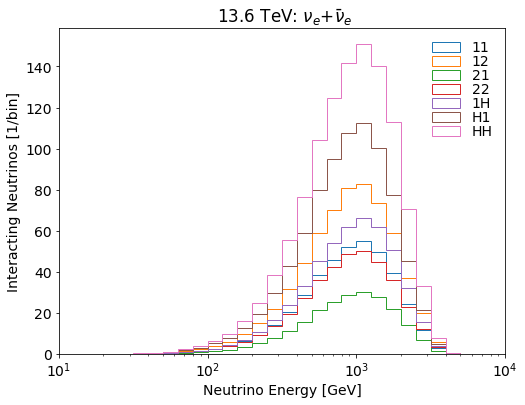

In [99]:
plot('charm', interaction=True)